#### Import from Libraries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import string
from tqdm import tqdm

# Downloading the NLTK stop word set
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ntsation/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Loading and Initial Data Inspection

In [24]:
df = pd.read_csv('data/covid19_tweets.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


#### Text Preprocessing

- Now, we will pre-process the texts to remove punctuations, stopwords and convert words to lowercase. The preprocess_text_optimized function is used to improve process efficiency.

In [25]:
# Function optimized for text preprocessing (remove punctuation and stopwords)
def preprocess_text_optimized(texts):
    stop_words = set(stopwords.words('english'))
    # Using list comprehension for greater efficiency
    return texts.apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]))

# Applying preprocessing
df['clean_text'] = preprocess_text_optimized(df['text'])

# Displaying the first lines of clean text
df[['text', 'clean_text']].head()


,text,clean_text
0,If I smelled the scent of hand sanitizers toda...,smelled scent hand sanitizers today someone pa...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey @yankees @yankeespr @mlb - made sense play...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realdonaldtrump trump nev...
3,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv one gift #covid19 give appreciati...
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 july : media bulletin novel #coronavirusupd...


#### Sentiment Analysis with TextBlob

- Now, let's apply TextBlob to calculate the sentiment polarity of each tweet, where a positive value indicates positive sentiment, negative indicates negative sentiment, and zero indicates neutral sentiment.

In [26]:
# Function for sentiment analysis using TextBlob
def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

# Applying sentiment analysis
df['sentiment'] = df['clean_text'].progress_apply(get_sentiment)

# Displaying sentiment distribution
df[['text', 'sentiment']].head()


100%|██████████| 179108/179108 [00:38<00:00, 4610.38it/s]


,text,sentiment
0,If I smelled the scent of hand sanitizers toda...,-0.25
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,0.00
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,0.00
3,@brookbanktv The one gift #COVID19 has give me...,0.00
4,25 July : Media Bulletin on Novel #CoronaVirus...,0.00


#### Sentiment Distribution Visualization

- Here, we will create a graph to visualize the distribution of sentiments in tweets.

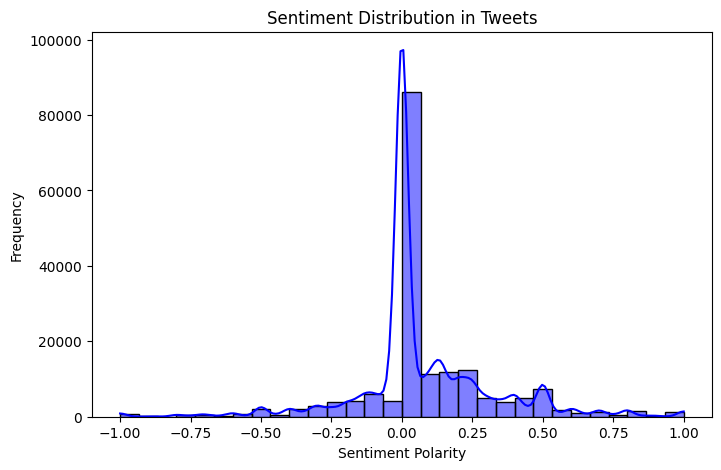

In [27]:
# Sentiment distribution graph
plt.figure(figsize=(8, 5))
sns.histplot(df['sentiment'], bins=30, kde=True, color='blue')
plt.title('Sentiment Distribution in Tweets')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


#### Topic Analysis with Latent Dirichlet Allocation (LDA)

- Now let's perform topic modeling using LDA. The process will be optimized to improve execution time by using fit_transform and adjusting the number of features in the CountVectorizer.

In [28]:
# Function to perform topic modeling using LDA in an optimized way
def get_lda_topics_optimized(texts, num_topics=5):
    # Vectorization with CountVectorizer (adjusting the number of features)
    vectorizer = CountVectorizer(max_df=0.85, max_features=3000, stop_words='english')
    X = vectorizer.fit_transform(texts)
    
    # LDA modeling with faster adjustment
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, n_jobs=-1) # Using n_jobs=-1 to parallelize
    lda_model = lda.fit_transform(X) # fit_transform instead of fit, to train and transform at once
    
    return lda, vectorizer

# Generating the LDA model with 5 topics
num_topics = 5
lda_model, vectorizer = get_lda_topics_optimized(df['clean_text'], num_topics=num_topics)

#### Display of Top Words by Topic

- Now let's visualize the most relevant words for each topic generated by LDA.

In [29]:
# Function to display top words by topic
def plot_lda_topics(lda_model, vectorizer, num_words=10):
    feature_names = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        print(f"\nTopic #{topic_idx + 1}:")
        print(' '.join(top_words))

# Displaying the most relevant words for each topic
plot_lda_topics(lda_model, vectorizer)


Topic #1:
covid19 people mask like amp know good realdonaldtrump masks year

Topic #2:
covid19 pandemic vaccine health amp coronavirus world trump says virus

Topic #3:
covid19 covid 19 coronavirus 2020 spread news august latest daily

Topic #4:
cases covid19 new deaths total india positive coronavirus reported 24

Topic #5:
covid19 amp day home safe lockdown week stay work 000


#### Visualization of Word Clouds for each Topic

- Here, we will create word clouds to visualize the topics identified by LDA.

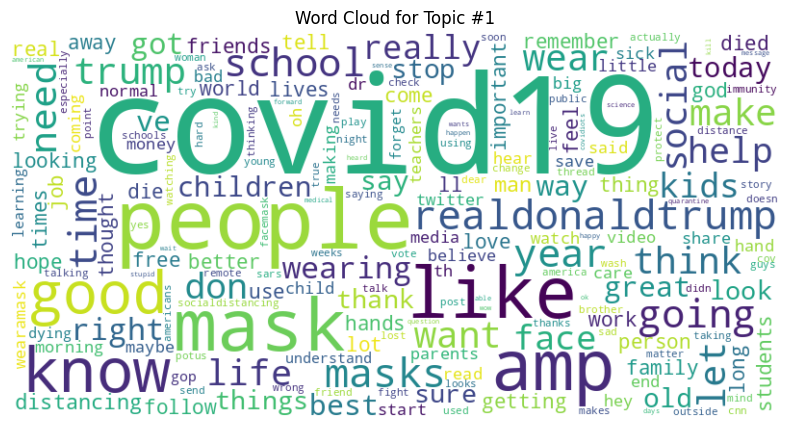

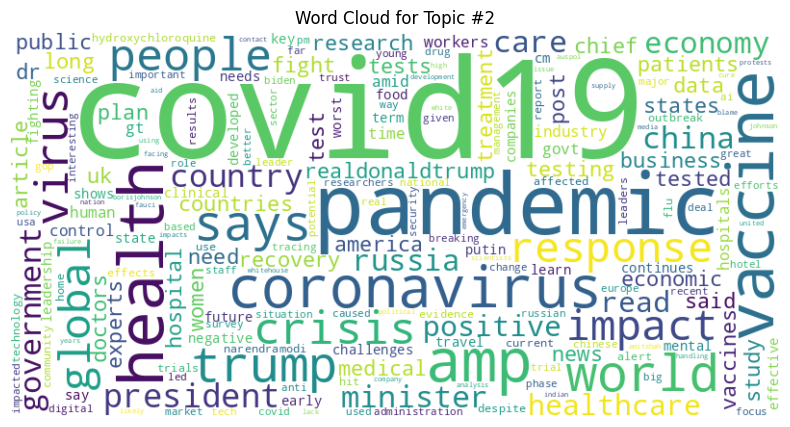

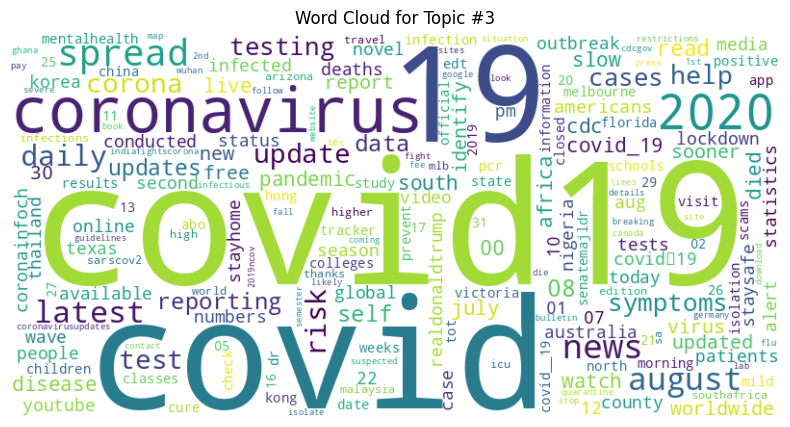

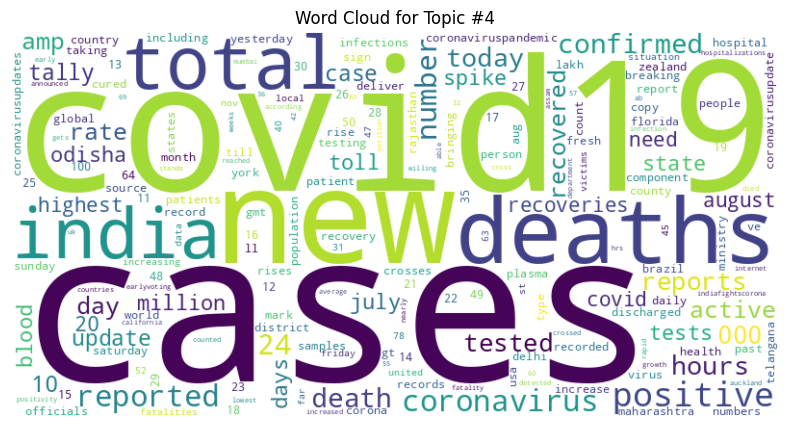

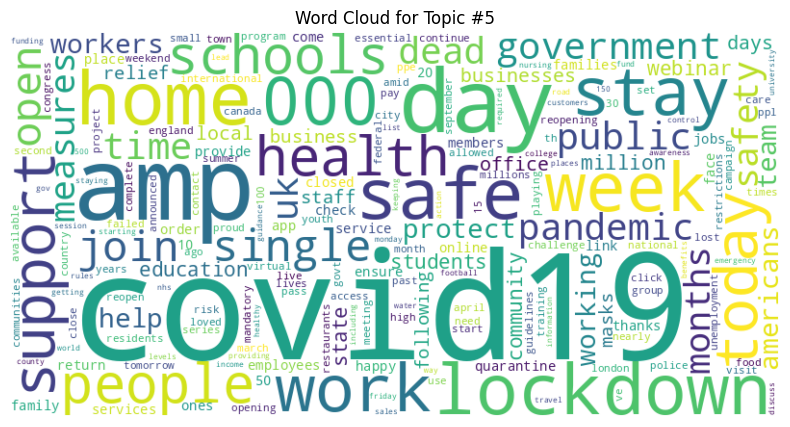

In [30]:
# Function to display word clouds for each topic
def plot_wordclouds(lda_model, vectorizer):
    for topic_idx, topic in enumerate(lda_model.components_):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
            dict(zip(vectorizer.get_feature_names_out(), topic))
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Topic #{topic_idx + 1}')
        plt.show()

# Generating word clouds for each topic
plot_wordclouds(lda_model, vectorizer)

#### Sentiment Classifier Training (Naive Bayes)

- Let's train a sentiment classification model using Naive Bayes. The model will classify sentiments into three categories: positive, negative and neutral.

In [31]:
# Defining the independent (X) and dependent (y) variables
X = df['clean_text']
y = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizing text data
vectorizer = CountVectorizer(max_df=0.85, max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Training the Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)

MultinomialNB()

#### Sentiment Classifier Evaluation

- Here, we will evaluate the performance of the Naive Bayes model using the accuracy, confusion matrix and classification report.

In [32]:
# Classifier predictions
y_pred = classifier.predict(X_test_vec)

# Classifier evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Ranking Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8449556138685724

Confusion Matrix:
[[ 3805  1044   875]
 [  504 14489  1187]
 [  790  1154 11974]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.66      0.70      5724
     neutral       0.87      0.90      0.88     16180
    positive       0.85      0.86      0.86     13918

    accuracy                           0.84     35822
   macro avg       0.82      0.81      0.81     35822
weighted avg       0.84      0.84      0.84     35822



### **Interpretation of Results**

Below, we interpret the results of the sentiment classification model based on accuracy, confusion matrix, and the classification report.

#### **1. Accuracy**
The **accuracy** of the model was **84.5%** (`0.8449`), meaning that, overall, the model correctly predicted the sentiment of 84.5% of the tweets. Although accuracy is an important metric, it is not sufficient on its own to evaluate the performance of a model in a multi-class classification problem, such as this one, which includes three classes: **negative**, **neutral**, and **positive**.

#### **2. Confusion Matrix**
The **confusion matrix** shows how the model's predictions compare to the actual labels. It consists of three main components:

|                | Predicted: Negative | Predicted: Neutral | Predicted: Positive |
|----------------|---------------------|--------------------|---------------------|
| **Actual: Negative** | 3805              | 1044               | 875                 |
| **Actual: Neutral**  | 504               | 14489              | 1187                |
| **Actual: Positive** | 790               | 1154               | 11974               |

Analyzing the confusion matrix:

- **Negative Class**: The model correctly classified 3805 tweets as negative, but also misclassified 1044 tweets as **neutral** and 875 as **positive**.
- **Neutral Class**: The neutral class was well-identified with 14489 correct predictions, though there was considerable confusion with the **negative** (504) and **positive** (1187) classes.
- **Positive Class**: The positive class performed well with 11974 correct predictions, but there was some confusion with the **negative** (790) and **neutral** (1154) classes.

This indicates that the most confusion occurs between the **neutral** and **positive** sentiments, which is expected, as many neutral tweets may be very close to positive ones in terms of polarity.

#### **3. Classification Report**
The **classification report** provides metrics such as **precision**, **recall**, and **f1-score** for each class, along with the weighted and macro averages.

- **Negative**:
  - **Precision (0.75)**: 75% of the tweets classified as negative were truly negative.
  - **Recall (0.66)**: Only 66% of the negative tweets were correctly identified as negative.
  - **F1-Score (0.70)**: The harmonic mean of precision and recall, which takes both aspects into account, was 0.70, indicating a reasonable performance in identifying negative tweets.

- **Neutral**:
  - **Precision (0.87)**: 87% of the tweets classified as neutral were truly neutral.
  - **Recall (0.90)**: The model correctly identified 90% of neutral tweets, which is excellent.
  - **F1-Score (0.88)**: The harmonic mean of precision and recall is very good, showing that the model has a strong balance between accuracy and capturing neutral tweets.

- **Positive**:
  - **Precision (0.85)**: 85% of the tweets classified as positive were truly positive.
  - **Recall (0.86)**: 86% of the positive tweets were correctly identified as positive, which is an excellent performance.
  - **F1-Score (0.86)**: The model had a balanced performance in the positive class, with a good balance between precision and recall.

#### **4. Average Metrics**
- **Macro Average**:
  - The average of the precision, recall, and F1 metrics for all classes, without considering the class imbalance, is quite solid: **precision (0.82)**, **recall (0.81)**, and **F1-Score (0.81)**. This suggests that the model performs well overall when all classes are treated equally.

- **Weighted Average**:
  - The weighted average takes the number of instances in each class into account. The model performed well across all classes with **precision (0.84)**, **recall (0.84)**, and **F1-Score (0.84)**.

### **Conclusions**
- The model has a strong overall performance, with an **accuracy of 84.5%**.
- The **Neutral Class** had the best performance in terms of **recall** (90%), which is expected, given that the model has more examples of this class.
- Performance in the **Negative** and **Positive** classes is reasonable, with **precision of 75%** and **85%**, respectively. However, the **Negative class** was a bit more difficult to identify correctly, with a recall rate of only 66%.
- The **macro** and **weighted averages** suggest that the model is well-balanced and efficient, considering the class imbalance in the dataset.

Overall, the **Naive Bayes** model has proven effective for sentiment analysis tasks, and further improvements could be made by tuning the model or exploring other approaches, such as neural networks or transformer-based models, to further enhance performance, especially in identifying negative sentiment.